# Attribute

**Direct Reference**: pinn_ode_tutorial-master github repositor

**Original Work**: *Renato Nascimento, Kajetan Fricke, Felipe Viana*
**Reference Github repo** https://github.com/PML-UCF/pinn_ode_tutorial.git

# Libraries and Dependencies

In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as matplotlib

from torch.nn.parameter import Parameter
from torch import (
    linalg,
    nn,
    Tensor,
    stack,
    cat,
    transpose, 
    optim,
    zeros,
    diag,
    reshape,
    rand,
    tanh,
    mean,
    square
    )

#For Data Generation
from scipy import signal
from scipy import linalg as linalg2
from scipy.integrate import odeint

# Hybrid RNN Code

### Construct / Deploy Hybrid RNN

In [15]:
class MyRNN(nn.Module):
    def __init__(self, cell, **kwargs):
        super(MyRNN, self).__init__()
        self.cell = cell

    def forward(self, inputs, initial_state):
        # Step into proceeding timestep
        bs, seq_sz, _ = inputs.shape
        state = []
        state.append(initial_state)
        for t in range(1, seq_sz): 
            input = inputs[:, t-1, :]
            state_t = self.cell.forward(input, state[t-1])
            state.append(state[t-1]+state_t)

        return stack((state),dim=1)

### Construct Runge-Kutta Cell

In [16]:
class RungeKuttaIntegratorCell(nn.Module):
    def __init__(self, beta, gamma, mu, u, dt, **kwargs):
        super(RungeKuttaIntegratorCell, self).__init__(**kwargs)

        self.beta_param = Parameter(beta)
        self.gamma_param = Parameter(gamma)
        self.mu_param = Parameter(mu)
        
        # Runge-Kutta iterative vectors
        self.state_size   =  4
        self.A  = Tensor([0., 0.5, 0.5, 1.0])
        self.B  = Tensor([[1/6, 2/6, 2/6, 1/6]])
        self.dt = dt
        
     #force parameters to be in a range
    @property
    def beta(self):
        return tanh(abs(self.beta_param))

    @property
    def gamma(self):
        return tanh(abs(self.gamma_param))

    @property
    def mu(self):
        return tanh(abs(self.mu_param))

    def forward(self, inputs, states):
        y = states
        #Perform Runge-Kutta computation
        ydoti = self._fun(beta, gamma, mu, y)
        yi = y + self.A[0]*ydoti*self.dt
        fn = self._fun(beta, gamma, mu, yi)
        #Perfom Runge-Kutta Computation
        for j in range(1,4):
            yn = y + self.A[j] * ydoti * self.dt
            fn = cat([fn, self._fun(beta, gamma, mu, yn)], dim=0)

        y    = linalg.matmul(self.B, fn) * self.dt
        return y

    def _fun(self, beta, gamma, mu, y):
        Sdot = -self.beta*y[0,0]*y[0,1]
        Idot = self.beta*y[0,0]*y[0,1] - self.gamma*y[0,1] - self.mu*y[0,1]
        Rdot = self.gamma*y[0,1]
        Ddot = self.mu*y[0,1]
        ydot = cat(([Sdot,Idot,Rdot,Ddot]), dim = -1)
        ydot = reshape(ydot,(1,4))

        return ydot

### Training Loop

In [17]:
def pinn_training_loop(n_epochs, optimizer, model, loss_fn, train, label, initial_state):
    mae = nn.L1Loss()
    losses = []
    betas = []
    gammas = []
    mus = []
    for epoch in range(1, n_epochs + 1):
        #Forward pass
        output_train = model(train, initial_state)
        loss_train = (mean(square(output_train[0,:,0] - label[0,:,0])) +
                        mean(square(output_train[0,:,1] - label[0,:,1])) + 
                        mean(square(output_train[0,:,2] - label[0,:,2])) +
                        mean(square(output_train[0,:,3] - label[0,:,3])))
        mae_train = mae(output_train, label)
        losses.append(loss_train.item())
        betas.append(beta.item())
        gammas.append(gamma.item())
        mus.append(mu.item())
        #Backward pass
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        #scheduler.step()

        print(f"Epoch {epoch}, Training loss {loss_train.item():.4e}, mae {mae_train.item():.4e}")
        
    return losses, betas, gammas, mus

### Execute Training

In [18]:
# initialize params randomly
beta = rand(1)
gamma = rand(1)
mu = rand(1)
print(tanh(abs(beta)))
print(tanh(abs(gamma)))
print(tanh(abs(mu)))

data = pd.read_csv('data/SIRD_organized_data.csv')
datanp = data.to_numpy()

# Total Ontario Population via Statcan (2020 estimate)
N = 14761811
#212 data points
S = datanp[:,1:2].astype('float64')
I = datanp[:,2:3].astype('float64')
R = datanp[:,3:4].astype('float64')
D = datanp[:,4:5].astype('float64')
# Normalize relative to static population estimate
Snorm = S/N
Inorm = I/N
Rnorm = R/N
Dnorm = D/N
#create a vector for time
t = np.linspace(0,211,212)
t = np.reshape(t,(212,1))
duration = 211

# data
dt = (t[1,0] - t[0,0])
t = Tensor(t)
Stense = Tensor(Snorm)
Itense = Tensor(Inorm)
Rtense = Tensor(Rnorm)
Dtense = Tensor(Dnorm)
ytrain = cat(([Stense,Itense,Rtense,Dtense]),dim=1)
utrain = zeros(ytrain.size())

#resize tensors
t = reshape(t,(len(t),1))
ufull = reshape(utrain, (1, len(t), 4))
yfull = reshape(ytrain, (1, len(t), 4))

# Initial state of the system 
initial_state = zeros(1,4)
initial_state[0,0] = Stense[0]
initial_state[0,1] = Itense[1]
initial_state[0,2] = Rtense[2]
initial_state[0,3] = Dtense[3]

rkCell = RungeKuttaIntegratorCell(beta = beta, gamma = gamma, mu = mu, u = ufull, dt=dt)
model = MyRNN(cell=rkCell)
    
#prediction results before training
yPred_before = model(ufull, initial_state)
yPred_before = yPred_before.detach().numpy()[0,:,:]

#check number of params
total_params = sum(p.numel() for p in model.parameters())
print(total_params)

#PINN training
losses, betas, gammas, mus = pinn_training_loop(
        n_epochs = 1000,
        optimizer = optim.Adam(model.parameters(), lr=5e-3),
        #scheduler = optim.lr_scheduler.CyclicLR(optim.Adam(model.parameters(), lr=1e-2), base_lr=1e-2, \
        #    max_lr=1e3, step_size_up=50, mode="exp_range", gamma=0.85, cycle_momentum=False),
        model = model,
        loss_fn = nn.MSELoss(),
        train = ufull,
        label = yfull,
        initial_state=initial_state
        )

tensor([0.0480])
tensor([0.1640])
tensor([0.1534])
3
Epoch 1, Training loss 1.2740e-04, mae 2.9722e-03
Epoch 2, Training loss 1.2735e-04, mae 2.9710e-03
Epoch 3, Training loss 1.2729e-04, mae 2.9699e-03
Epoch 4, Training loss 1.2724e-04, mae 2.9687e-03
Epoch 5, Training loss 1.2718e-04, mae 2.9674e-03
Epoch 6, Training loss 1.2712e-04, mae 2.9661e-03
Epoch 7, Training loss 1.2706e-04, mae 2.9646e-03
Epoch 8, Training loss 1.2698e-04, mae 2.9630e-03
Epoch 9, Training loss 1.2690e-04, mae 2.9611e-03
Epoch 10, Training loss 1.2680e-04, mae 2.9590e-03
Epoch 11, Training loss 1.2668e-04, mae 2.9565e-03
Epoch 12, Training loss 1.2655e-04, mae 2.9536e-03
Epoch 13, Training loss 1.2638e-04, mae 2.9501e-03
Epoch 14, Training loss 1.2618e-04, mae 2.9458e-03
Epoch 15, Training loss 1.2592e-04, mae 2.9405e-03
Epoch 16, Training loss 1.2559e-04, mae 2.9338e-03
Epoch 17, Training loss 1.2514e-04, mae 2.9249e-03
Epoch 18, Training loss 1.2452e-04, mae 2.9128e-03
Epoch 19, Training loss 1.2360e-04, ma

### Visualize Results

0.16670629213412505
0.14823855469098535
0.0027650077212063944


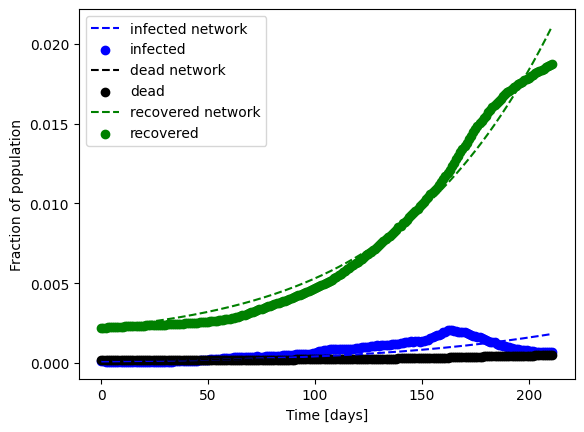

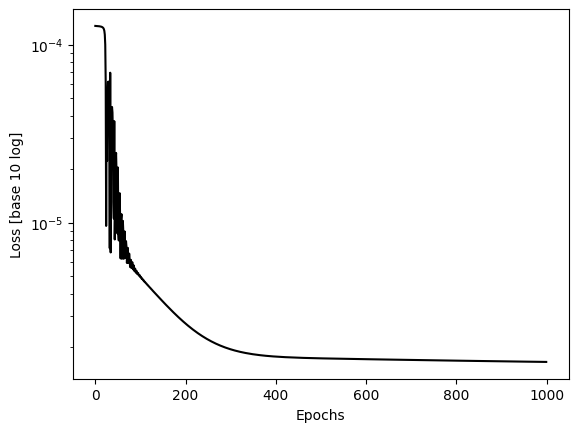

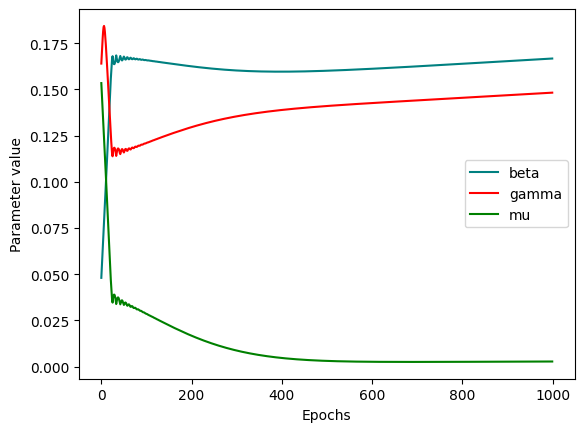

In [20]:
# constrained params
beta_con = np.tanh(betas)
gamma_con = np.tanh(gammas)
mu_con = np.tanh(mus)
beta_con = list(map(abs, beta_con))
gamma_con = list(map(abs, gamma_con))
mu_con = list(map(abs, mu_con))
print(beta_con[-1])
print(gamma_con[-1])
print(mu_con[-1])
#prediction results after training
yPred = model(ufull, initial_state) [0, :, :]
yPred = yPred.detach().numpy()

#plt.plot(t, yPred[:,0], color = 'red', label = 'susceptible network', linestyle = 'dashed')
#plt.scatter(t, Snorm, color = 'red', label = 'susceptible')

plt.plot(t, yPred[:,1], color = 'blue', label = 'infected network', linestyle = 'dashed')
plt.scatter(t, Inorm, color = 'blue', label = 'infected')
plt.plot(t, yPred[:,3], color = 'black', label = 'dead network', linestyle = 'dashed')
plt.scatter(t, Dnorm, color = 'black', label = 'dead')
plt.plot(t, yPred[:,2], color = 'green', label = 'recovered network', linestyle = 'dashed')
plt.scatter(t, Rnorm, color = 'green', label = 'recovered')


plt.legend()
#plt.title('Network recreation of training dataset')
plt.xlabel('Time [days]')
plt.ylabel('Fraction of population')
plt.show()

# Loss
plt.plot(losses,color = 'black')
plt.yscale("log")
#plt.title("Loss trend under Adam optimization")
plt.xlabel('Epochs')
plt.ylabel('Loss [base 10 log]')
plt.show()

# plot the learned SIRD parameters vs true SIRD parameters
plt.plot(beta_con[0:], color = 'teal', label ="beta")
plt.plot(gamma_con[0:], color = 'red', label="gamma")
plt.plot(mu_con[0:], color = 'green', label="mu")
plt.legend()
#plt.title('Change in Parameter estimation')
plt.xlabel('Epochs')
plt.ylabel('Parameter value')
plt.show()